## The inviscid Burgers' Equation

#### Problem Setup

Then $u_0(x) := u(x,0) = x$

Using the backward Euler scheme, the equation can be re-written as:

$\frac{u_n - u_{n-1}}{\tau} + c u_n \frac{d}{dx}u_n  = 0$

We set $u_n = \mu_{n-1}$, where $\mu_{n-1}$ is the mean of $u_{n-1}$, to deal with the non-linearity:

$u_n + \tau c \mu_{n-1} \frac{d}{dx}u_n = u_{n-1}$


Consider $u_n$ to be a Gaussian process.

$u_n \sim \mathcal{GP}(0, k_{uu}(x_i, x_j; \theta, l))$

And the linear operator:

$\mathcal{L}_x^c = \cdot + \tau c \mu_{n-1} \frac{d}{dx}\cdot$

so that

$\mathcal{L}_x^c u_n = u_{n-1}$

Problem at hand: Estimate $c$. Using 20 data points, we will be able to estimate c to be 0.9994.

For the sake of simplicity, take $u := u_n$ and $f := u_{n-1}$.


#### Step 1: Simulate data

Take data points at $t = 0$ for $(u_{n-1})$ and $t = \tau$ for $(u_n)$, where $\tau$ is the time step.

In [109]:
import numpy as np
import sympy as sp
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import warnings
import time

$x \in [0, 1], \; t \in \{0, \tau \}$

In [3]:
tau = 0.001
def get_simulated_data(tau, n=20):
    x = np.random.rand(n)
    y_u = x/(1+tau)
    y_f = x
    return (x, y_u, y_f)

(x, y_u, y_f) = get_simulated_data(tau)

In [5]:
def show_1(x,y_u,y_f):
    f, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, sharey=True, figsize=(10,3))
    f.suptitle("Data for u(x) in red and f(x) in blue")
    ax1.plot(x, y_u, 'ro')
    ax1.set(xlabel= r"x", ylabel= "u(x)")
    ax2.plot(x, y_f, 'bo')
    ax2.set(xlabel= r"x", ylabel= "f(x)");

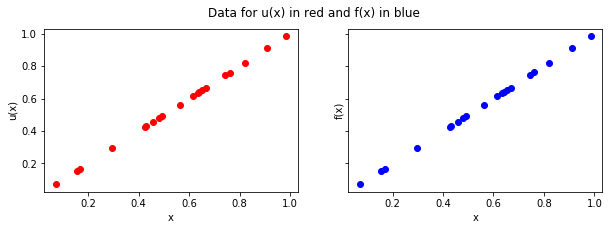

In [6]:
show_1(x,y_u,y_f)

#### Step 2: Evaluate kernels

1) $k_{uu}(x_i, x_j; \theta, l) = \theta exp(-\frac{1}{2l}(x_i-x_j)^2)$, where $\theta, l > 0$

In [7]:
x_i, x_j, theta, l, c = sp.symbols('x_i x_j theta l c')
mu = np.mean(y_f)
kuu_sym = theta*sp.exp(-1/(2*l)*((x_i - x_j)**2))
kuu_fn = sp.lambdify((x_i, x_j, theta, l), kuu_sym, "numpy")
def kuu(x, theta, l):
    k = np.zeros((x.size, x.size))
    for i in range(x.size):
        for j in range(x.size):
            k[i,j] = kuu_fn(x[i], x[j], theta, l)
    return k

2) $k_{ff}(x_i,x_j;\theta, l, c)
= \mathcal{L}_{x_i}^c \mathcal{L}_{x_j}^c k_{uu}(x_i, x_j; \theta, l) \\
= k_{uu} + \tau c \mu_{n-1} \frac{d}{dx_i}k_{uu} + \tau c \mu_{n-1} \frac{d}{dx_j}k_{uu} + \tau^2 c^2 \mu_{n-1}^2 \frac{d^2}{d x_i x_j} k_{uu}$

In [8]:
kff_sym = kuu_sym \
        + tau*c*mu*(sp.diff(kuu_sym, x_i) + sp.diff(kuu_sym, x_j)) \
        + tau**2*c**2*mu**2*sp.diff(kuu_sym, x_i, x_j)
kff_fn = sp.lambdify((x_i, x_j, theta, l, c), kff_sym, "numpy")
def kff(x, theta, l, c):
    k = np.zeros((x.size, x.size))
    for i in range(x.size):
        for j in range(x.size):
            k[i,j] = kff_fn(x[i], x[j], theta, l, c)
    return k

3) $k_{fu}(x_i,x_j; \theta, l, c)
= \mathcal{L}_{x_i}^c k_{uu}(x_i, x_j; \theta, l) \\
= k_{uu} + \tau \mu_{n-1} c \frac{d}{dx_i}k_{uu}$

In [9]:
kfu_sym = kuu_sym + tau*mu*c*sp.diff(kuu_sym, x_i)
kfu_fn = sp.lambdify((x_i, x_j, theta, l, c), kfu_sym, "numpy")
def kfu(x, theta, l, c):
    k = np.zeros((x.size, x.size))
    for i in range(x.size):
        for j in range(x.size):
            k[i,j] = kfu_fn(x[i], x[j], theta, l, c)
    return k

4) $k_{uf}(x_i,x_j;\theta, l, c)$ is given by the transpose of $k_{fu}(x_i,x_j;\theta, l, c)$

In [10]:
def kuf(x, theta, l, c):
    return kfu(x,theta, l, c).T

#### Steps 3 and 4: Compute NLML and optimize the hyperparameters

In [11]:
def nlml(params, x, y1, y2, s):
    theta_exp = np.exp(params[0]) 
    l_exp = np.exp(params[1])
    K = np.block([
        [kuu(x, theta_exp, l_exp) + s*np.identity(x.size), kuf(x, theta_exp, l_exp, params[2])],
        [kfu(x, theta_exp, l_exp, params[2]), kff(x, theta_exp, l_exp, params[2]) + s*np.identity(x.size)]
    ])
    y = np.concatenate((y1, y2))
    val = 0.5*(np.log(abs(np.linalg.det(K))) + np.mat(y) * np.linalg.inv(K) * np.mat(y).T)
    return val.item(0)

In [ ]:
m = minimize(nlml, np.random.rand(3), args=(x, y_u, y_f, 1e-7), method=\
             "Nelder-Mead", options = {'maxiter' : 1000})

In [11]:
m.x[2]  # This is our inferred value for c

0.9994300669651587

In [12]:
m

 final_simplex: (array([[6.72217068, 7.81870533, 0.99943007],
       [6.72217757, 7.81870686, 0.99942905],
       [6.72224191, 7.81878793, 0.9994286 ],
       [6.72221172, 7.81875754, 0.99942915]]), array([-293.59378882, -293.59377864, -293.59377797, -293.59377179]))
           fun: -293.59378881947436
       message: 'Optimization terminated successfully.'
          nfev: 225
           nit: 116
        status: 0
       success: True
             x: array([6.72217068, 7.81870533, 0.99943007])

#### Step 5: Analysis w.r.t. the number of data points (up to 25):

In this section we want to analyze the error of our algorithm using two different ways and plot its time complexity.

In [13]:
res = np.zeros((5,25))
timing = np.zeros((5,25))
warnings.filterwarnings("ignore")
for k in range(5):
    for n in range(25):
        start_time = time.time()
        (x, y_u, y_f) = get_simulated_data(tau, n)
        m = minimize(nlml, np.random.rand(3), args=(x, y_u, y_f, 1e-7), method="Nelder-Mead")
        res[k][n] = m.x[2]
        timing[k][n] = time.time() - start_time

**1. Plotting the error in our estimate for c:**

The error is given by $| c_{estimate} - c_{true} |$.

In [ ]:
lin = np.linspace(5, res.shape[1] - 1, res.shape[1] - 5)
ones = np.ones(res.shape[1])

def show_2(lin, ones, res):
plt.figure(figsize=(5,3))
to_del = np.linspace(0, 4, 5)
for i in range(res.shape[0]):
    a = np.delete(np.abs(res[i,:] - ones), to_del)
    plt.plot(lin, a)
    plt.ylabel('Error')
    plt.xlabel('Number of data points')
    plt.show()

We have altogether ran the algorithm five times, each time increasing the number of data points:

In [152]:
# The rows of res consist of the predicted values for c with an increasing 
# number of samples. The number of rows correspond to the amount of reruns 
# and thereby resulting plots.

%matplotlib inline
import matplotlib.ticker as ticker

# Setting global figsize to (5,3)
import matplotlib
matplotlib.rcParams["figure.figsize"] = (5,3)

lin = np.linspace(5, res.shape[1] - 1, res.shape[1] - 5)
ones = np.ones(res.shape[1])

def show_2(lin, ones, res):
    
    to_del = np.linspace(0, 4, 5)
    
    # Forcing integer labels for the x-axis.
    ax = plt.figure().gca()
    ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
    
    for i in range(res.shape[0]):
        a = np.delete(np.abs(res[i,:] - ones), to_del)
        plt.plot(lin, a)
        plt.ylabel('Error')
        plt.xlabel('Number of data points')

    est = np.repeat(0.46, len(lin))
    plt.plot(lin, est, color='blue', linestyle='dashed')
    plt.show();

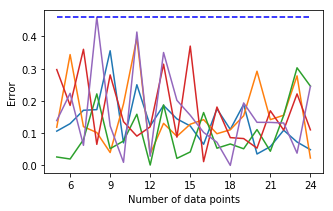

In [153]:
show_2(lin, ones, res)

We see that for n sufficiently large (in this case $n \geq 5$), we can assume the error to be bounded by 0.46. <br>
It seems to be difficult to (even roughly) describe the limiting behavior of the error w.r.t. the number of data points.

**2. Plotting the error between the solution and the approximative solution:**

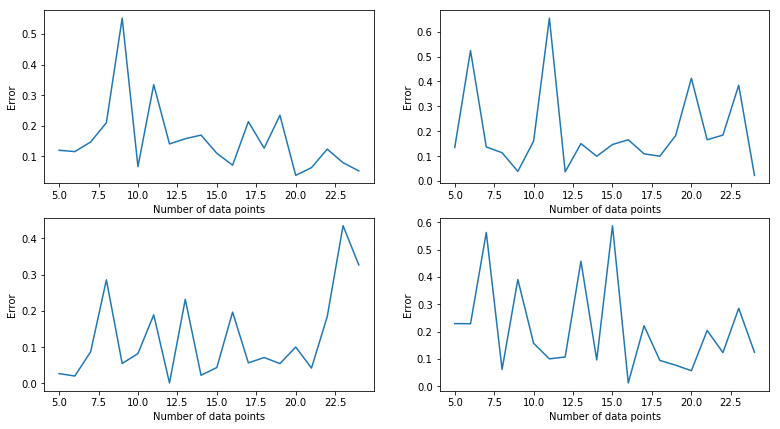

In [16]:
lin = np.linspace(5, res.shape[1] - 1, res.shape[1] - 5)
ones = np.ones(res.shape[1])
to_del = np.linspace(0, 4, 5)

f, (ax1, ax2) = plt.subplots(ncols=2, nrows=2, figsize=(13,7))

a0 = np.delete(np.abs(np.divide(ones, res[0,:]) - ones), to_del)
ax1[0].plot(lin, a0)
ax1[0].set(xlabel= r"Number of data points", ylabel= "Error")

a1 = np.delete(np.abs(np.divide(ones, res[1,:]) - ones), to_del)
ax1[1].plot(lin, a1)
ax1[1].set(xlabel= r"Number of data points", ylabel= "Error")

a2 = np.delete(np.abs(np.divide(ones, res[2,:]) - ones), to_del)
ax2[0].plot(lin, a2)
ax2[0].set(xlabel= r"Number of data points", ylabel= "Error")

a3 = np.delete(np.abs(np.divide(ones, res[3,:]) - ones), to_del)
ax2[1].plot(lin, a3)
ax2[1].set(xlabel= r"Number of data points", ylabel= "Error");

In [154]:
lin = np.linspace(5, res.shape[1] - 1, res.shape[1] - 5)
ones = np.ones(res.shape[1])

def show_3(lin, ones, res):
    plt.figure(figsize=(5,3))
    
    to_del = np.linspace(0, 4, 5)
    
    ax = plt.figure().gca()
    ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
    
    plt.suptitle('Relative error in our estimated solution')
    plt.ylabel('Error')
    plt.xlabel('Number of data points')
    
    for i in range(res.shape[0]):
        a_i = np.delete(np.abs(np.divide(ones, res[i,:]) - ones), to_del)
        plt.plot(lin, a_i)


<Figure size 360x216 with 0 Axes>

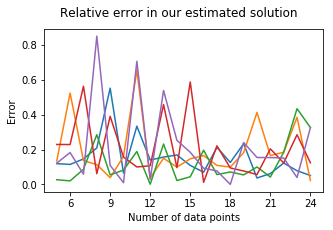

In [155]:
show_2(lin, ones, res)

**3. Plotting the execution time:**

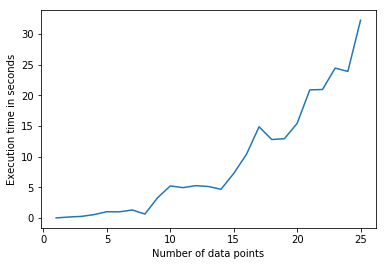

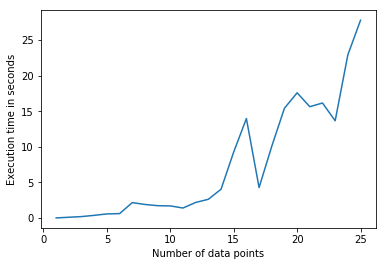

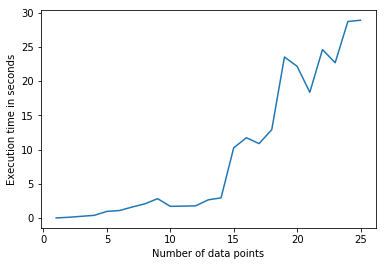

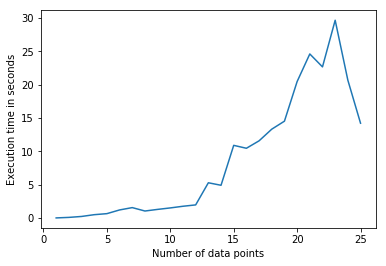

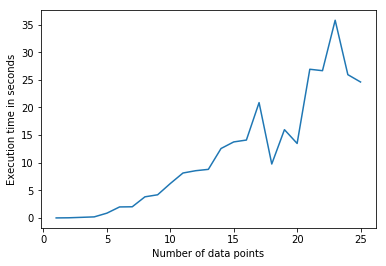

In [19]:
lin = np.linspace(1, timing.shape[1], timing.shape[1])

for i in range(timing.shape[0]):
    plt.plot(lin, timing[i,:])
    plt.ylabel('Execution time in seconds')
    plt.xlabel('Number of data points')
    plt.show()

All in one plot (the blue dashed line follows $f(x) = 0.01x^{2.2}$):

In [91]:
lin = np.linspace(1, timing.shape[1], timing.shape[1])

def show_3(lin, timing):
    plt.figure(figsize=(5,3))
    
    for i in range(timing.shape[0]):
        plt.plot(lin, timing[i,:])
        plt.suptitle('Execution time of our algorithm')
        plt.ylabel('Seconds')
        plt.xlabel('Number of data points')

    est = 0.01*(lin)**(2.2)
    plt.plot(lin, est, color='blue', linestyle='dashed')
    plt.show()

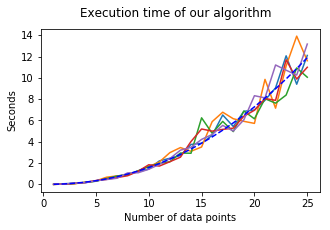

In [92]:
show_3(lin, timing)

The time complexity seems to be around $\mathcal{O}(n^{2.2})$ (blue-dashed line).